# Uncertainty

This notebook examines uncertainty in Atomica, going through

- How uncertainty in model inputs is entered
- How to perform simulations that are sampled from the distribution of parameters with uncertainty
- How to perform analyses that incorporate uncertainty

## Specifying uncertainty

Fundmentally, uncertainty enters Atomica via the data entry spreadsheets. Both the databook and program book have columns that can be used to enter uncertainty. 

In the databook, uncertainty can be added to any TDVE table - that is, any of the sub-tables within the databook for each quantity. By default, those columns are not produced when the databook is written e.g. with 

    proj.data.save('databook.xlsx')
    
If you want to include those columns, use the `write_uncertainty` options:

    proj.data.save('databook.xlsx',write_uncertainty=True)
    
This will add an 'uncertainty' column to all tables in the databook. If you only want to add uncertainty to a small number of quantities, you can simply insert an extra column for the tables that you want to add uncertainty to, by selecting the other cells and moving them over. The example below shows how an uncertainty column has been added to the 'Screened people' table and not to the 'All people with condition' table:

![image.png](assets/databook_uncertainty.png)


<div class="alert alert-info">
Uncertainty should be entered as a standard deviation, with the same units as the quantity itself
</div>

In the example above, it would be accurate to state that the 2016 value for the number of screened people in the male rural population is $214 \pm 20$. Mathematically, the entry above corresponds to specifying that the distribution of screened people in the male rural population has a mean of 214 and a standard deviation of 20. 

For the program book, uncertainty appears in two places - in the spending/coverage sheet, and in the outcome sheet, as shown below. These columns are always present in the program book.


![image.png](assets/progbook_spending_uncertainty.png)
![image.png](assets/progbook_outcome_uncertainty.png)


To limit complexity in data entry, only a single uncertainty value can be entered for each quantity. That is, in the databook and spending/coverage sheet, uncertainty cannot vary over time, and in the outcome sheet, the uncertainty is specified at the parameter-population level, and applies to all programs reaching that parameter. 

## Sampling inputs

We have seen above how to enter uncertainty in the databook and program book. These uncertainties are loaded into the corresponding `ProjectData` and `ProgramSet` objects in Atomica. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('..')

In [2]:
import atomica as at
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sciris as sc
np.random.seed(3)
testdir = at.atomica_path('tests')

P = at.Project(framework=testdir + 'test_uncertainty_framework.xlsx', databook=testdir + 'test_uncertainty_databook.xlsx')
P.load_progbook(testdir + 'test_uncertainty_high_progbook.xlsx')

low_uncertainty_progset = at.ProgramSet.from_spreadsheet(testdir + 'test_uncertainty_low_progbook.xlsx',project=P)
high_uncertainty_progset = at.ProgramSet.from_spreadsheet(testdir + 'test_uncertainty_high_progbook.xlsx',project=P)
default_budget = at.ProgramInstructions(start_year=2018, alloc=P.progsets[0])
doubled_budget = default_budget.scale_alloc(2)


Atomica 1.0.18 (2018-12-18) -- (c) the Atomica development team
2019-01-29 13:42:28.308746


Elapsed time for running "default": 0.0210s


Above, we have loaded in a databook with uncertainty values, and also loaded in two different program books, one with low uncertainty, and one with high uncertainty. We can inspect the objects to see how the uncertainty entered in the spreadsheets is reflected in code. 

In [3]:
P.data.tdve['all_screened'].ts[0]

Methods:
  copy()              insert()            remove_between()    
  get()               interpolate()       sample()            
  get_arrays()        remove()            
  _sampled: False
assumption: None
     sigma: 20.0
         t: [2016.0]
     units: Number
      vals: [214.0]

The uncertainty value is attached to the underlying `TimeSeries` objects, and stored in the `sigma` property. When running a simulation, we specify a `ParameterSet` and optionally a `ProgramSet`:

Elapsed time for running "default": 0.0230s


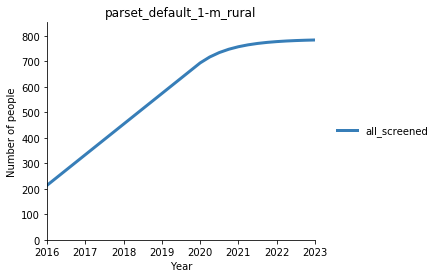

In [4]:
parset = P.parsets[0]
res = P.run_sim(parset)
d = at.PlotData(res,'all_screened',pops='m_rural')
at.plot_series(d);

If there is uncertainty, we can obtain a sampled epidemiological prediction by sampling from all of the quantities containing uncertinty. For example, replacing the value of `214` above with a sample from the distribution $\ \mathcal{N}(214,20)$ - along with all of the other quantities. The input to the model is effectively a parameter set derived from the original set of parameters, but with values replaced by sampled values where appropriate. You can obtain a sampled parameter set simply by calling the `ParameterSet.sample()` method:

In [5]:
sampled_parset = parset.sample()

Now compare the values for the screening parameter in the original parset and the sampled parset:

In [6]:
print('Original parameters: %.2f' % (parset.pars['all_screened'].ts['m_rural'].vals[0]))
print('Sampled parameters: %.2f' % (sampled_parset.pars['all_screened'].ts['m_rural'].vals[0]))

Original parameters: 214.00
Sampled parameters: 249.77


The original parameters contain the values entered in the databook, while the sampled parameters have the values perturbed by the sampling. Although the sampled parameters retain the original uncertainty values, you can only perform sampling once:

In [7]:
try:
    sampled_parset.sample()
except Exception as e:
    print(e)

Sampling has already been performed - can only sample once


To run a sampled simulation, it is thus only necessary to pass the sampled `ParameterSet` into `Project.run_sim` instead of the original parameters:

Elapsed time for running "default": 0.0210s


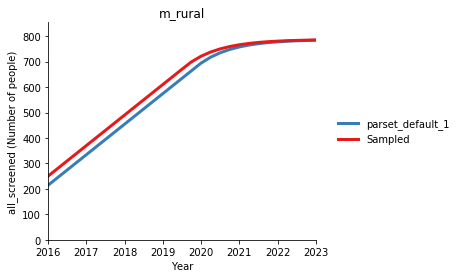

In [8]:
sampled_res = P.run_sim(sampled_parset,result_name='Sampled')
d = at.PlotData([res,sampled_res],'all_screened',pops='m_rural')
at.plot_series(d,axis='results');

Exactly the same procedure is used for programs - the `ProgramSet` has a `sample()` method which returns a sampled `ProgramSet` that can be used instead of the original `ProgramSet` to perform a sampled simulation:

Elapsed time for running "default": 0.0650s
Elapsed time for running "default": 0.0290s


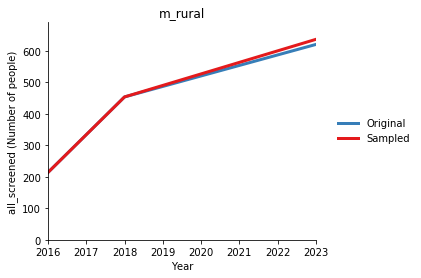

In [9]:
sampled_progset = high_uncertainty_progset.sample()
res = P.run_sim(parset,high_uncertainty_progset,progset_instructions=default_budget,result_name='Original')
sampled_res = P.run_sim(parset,sampled_progset,progset_instructions=default_budget,result_name='Sampled')
d = at.PlotData([res,sampled_res],'all_screened',pops='m_rural')
at.plot_series(d,axis='results');

Of course, we can combine the sampled parset and the sampled progset in a single simulation to sample from both sources of uncertainty simultaneously:

Elapsed time for running "default": 0.0290s


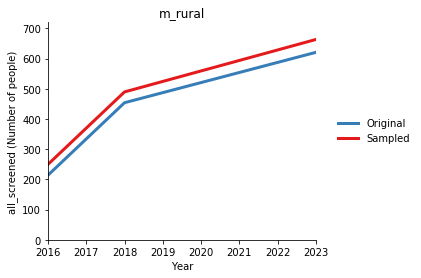

In [10]:
sampled_res = P.run_sim(sampled_parset,sampled_progset,progset_instructions=default_budget,result_name='Sampled')
d = at.PlotData([res,sampled_res],'all_screened',pops='m_rural')
at.plot_series(d,axis='results');

One issue when sampling is that of satisfying initial conditions. Databooks often require some work to ensure that none of the initial compartment sizes are negative. If uncertainties are specified for characteristics that are used for initialization, it is possible that the independently-sampled characteristic values yield a bad initialization (where some of the compartment sizes are negative, or the characteristic values are otherwise inconsistent). If this happens, a `BadInitialization` error is raised. Therefore, to write reliable sampling code, it is essential to catch this exception:

In [11]:
np.random.seed(1) # This seed provides a BadInitialization at the next iteration
sampled_parset = parset.sample()
try:
    sampled_res = P.run_sim(sampled_parset)
except at.BadInitialization as e:
    print(e)

Negative initial popsizes:
Compartment f_rural scr - Calculated -11.235128
Characteristic 'all_people': Target value = [1101.]
	Compartment undx: Computed value = 630.235128
	Compartment scr: Computed value = -11.235128
	Compartment dx: Computed value = 100.000000
	Compartment tx: Computed value = 234.000000
	Compartment con: Computed value = 148.000000
Characteristic 'all_screened': Target value = [470.76487173]
	Compartment scr: Computed value = -11.235128
	Compartment dx: Computed value = 100.000000
	Compartment tx: Computed value = 234.000000
	Compartment con: Computed value = 148.000000



When this error occurs, the correct thing to do is usually to just sample again on the assumption that other samples may satisfy the initial conditions. Thus, sampling would be carried out within a `while` loop that continues until a simulation is successfully run. To automate this, we can use `Project.run_sampled_sims` which functions similarly to `Project.run_sim()` except that it incorporates a sampling step together with automated resampling if the initial conditions are unsatisfactory

In [12]:
sampled_res = P.run_sampled_sims(parset)
print(sampled_res)

[[<atomica.results.Result at 0x15d136096d8>
Methods:
  budget()            export_raw()        link_names()        
  charac_names()      get_alloc()         par_names()         
  comp_names()        get_coverage()      plot()              
  copy()              get_variable()      
    created: datetime.datetime(2019, 1, 29, 13, 42, 31, 769616)
      model: <atomica.model.Model object at 0x0000015D136095F8>
   modified: datetime.datetime(2019, 1, 29, 13, 42, 31, 769616)
       name: default
parset_name: default
  pop_names: ['m_rural', 'f_rural', 'm_urban', 'f_urban']
        uid: UUID('eb074b0c-929f-43ad-82b8-2d325c84e2fd')
]]


Note that the return value is a list of results, rather than just a `Result` like with `Project.run_sim()`. Typically, uncertainties require working with multiple samples. Thus, you can also pass in a number of samples, and `Project.run_sampled_sims()` will return the required number of sampled results:

In [13]:
sampled_res = P.run_sampled_sims(parset,n_samples=5)
print(len(sampled_res))

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 37.33it/s]


5


When running multiple sampled simulations, a progress bar with estimated time remaining will be displayed.

## Analysis

Now that we are able to run simulations with sampled parameters, the next question is how to produce analysis outputs such as plots that have error bars or otherwise visually represent uncertainty. The first step to doing this is to obtain a collection of results. The number of samples required loosely depends on the number of quantities with uncertainty - a general rule of thumb though is that the number of samples required would generally be on the order of 50-200. 

In [14]:
sampled_res = P.run_sampled_sims(parset,n_samples=100)

100%|████████████████████████████████████████| 100/100 [00:03<00:00, 32.46it/s]


For comparison, we will also run a 'baseline' simulation with no sampling. A plot of the baseline results looks like this:

Elapsed time for running "default": 0.0230s


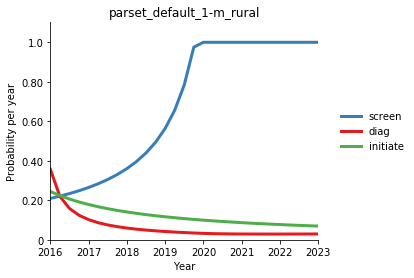

In [15]:
baseline = P.run_sim(parset)
d = at.PlotData(baseline,outputs=['screen','diag','initiate'],pops='m_rural')
at.plot_series(d);

### Basic plotting

The normal sequence for plotting is that we would 

1. Instantiate a `PlotData` object with the quantities to plot. Effectively, this operation is mapping a `Result` to a `PlotData`
2. Call a plotting library function to generate the plot

Plots generated with the plotting library compare multiple results (e.g. different scenarios) rather than showing uncertainty computed over an ensemble of results. Further, they only take in a single `PlotData` instance where the results to compare have been included in the same `PlotData` object. 

To work with uncertainty, instead of plotting a single `PlotData` object, we instead plot a collection of `PlotData` objects. And plots are generated using a different set of plotting functions that take in multiple `PlotData` instances and use them to compute and display uncertainties (e.g. as error bars or as shaded areas).

This functionality is accessed via the `Ensemble` class. The `Ensemble` class is designed to store and plot ensembles of results. Internally, it stores a list of `PlotData` objects - one for each sample. It also contains a 'mapping function' that takes in results and returns a `PlotData` instance. To use an Ensemble, first we need to define a mapping function. In the simplest case, this looks just like a normal call to `PlotData()`:

In [16]:
mapping_function = lambda x: at.PlotData(x,outputs=['screen','diag','initiate'],pops='m_rural')

Then, we create an `Ensemble`:

In [17]:
ensemble = at.Ensemble(mapping_function=mapping_function)

We then need to load all of the results into the mapping function. Similar to Python's built-in `set` class, there are two ways of inserting the results

- One by one, using `Ensemble.add(result)`
- All at once, using `Ensemble.update(list_of_results)`

In our case, we already have a list of results generated by `P.run_sampled_sims`, so we can go ahead and use `Ensemble.update()` to insert them

In [18]:
ensemble.update(sampled_res)

Finally, we can make some plots. To start with, let's make a plot of the time series like the one shown above for the baseline results, but with uncertainty this time:

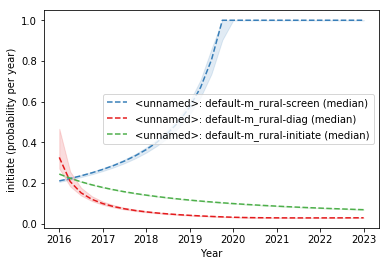

In [19]:
ensemble.plot_series();

As we have only loaded in the sampled results, the dashed line corresponds to the median of the samples. The shaded areas show the area between the first and third quartiles for the samples. To start with, instead of showing the median of the samples, it is generally more appropriate to show the actual baseline results. To do this, we can load the baseline results into the Ensemble and then regenerate the plot.

<div class="alert alert-warning">
The baseline results need to have the same names as the sampled results. If you do not explicitly specify names, `Project.run_sampled_sims` produces default names that avoid collisions between multiple instructions. However, `Project.run_sim` produces default names that avoid collisions with other results stored in the project. Therefore, it may be necessary to explicitly set or change the result names if the names were set differently.
</div>

In this case, the baseline results need to have their name changed to `'default'` to match the sampled results:

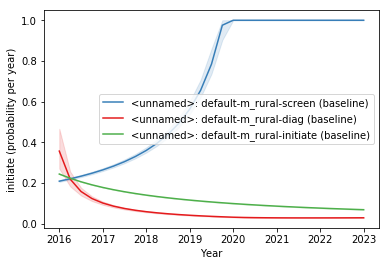

In [20]:
baseline.name = 'default'
ensemble.set_baseline(baseline)
ensemble.plot_series();

As with the rest of the plotting library, the legend is 'maximally informative' in that it contains as much information as possible. This is because the most appropriate labelling for the figure (whether the axis labels, titles, or legend entries) varies greatly with context, and it is often necessary to relabel the figure on a plot-by-plot basis. This relabelling is facilitating by having all of the necessary content on the figure, rather than having to keep track of it separately. Thus, it is expected that the labels may need to be edited afterwards depending on usage.

The `'<unnamed'>` string corresponds to the name of the ensemble. We hadn't given the ensemble a name, but naming the ensemble can be useful if you want to superimpose multiple ensembles on the same plot. The ensemble can be named at construction, or at any point subsequently:

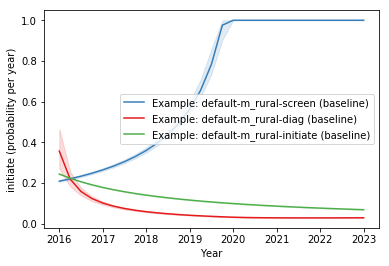

In [21]:
ensemble.name = 'Example'
ensemble.plot_series();

Now, the baseline results are displayed as solid lines. Other types of plots can be generated too. 

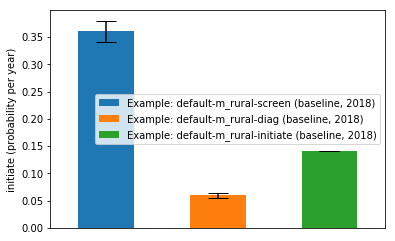

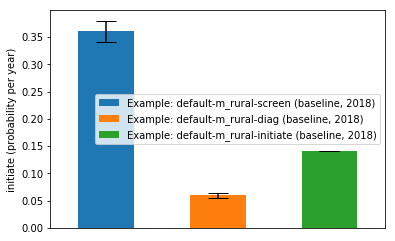

In [22]:
ensemble.plot_bars(years=2018)

Because the `Ensemble` stores `PlotData` objects, you can perform any aggregation operations in the same way as normal. For example, we can plot the years lost to disability by integrating the number of people in the disease compartments.

In [23]:
yld = lambda x: at.PlotData(x,outputs={'disease':['undx','scr','dx','tx']},t_bins=[2018,2023],time_aggregation='integrate')

This is the usual way that this plot would be generated for a single `Result` without uncertainty, and indeed we can go ahead and generate that plot now

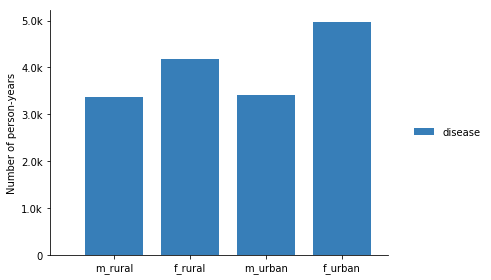

In [31]:
d = yld(baseline)
at.plot_bars(d);

With uncertainty, we simply make the plot via an `Ensemble` instead

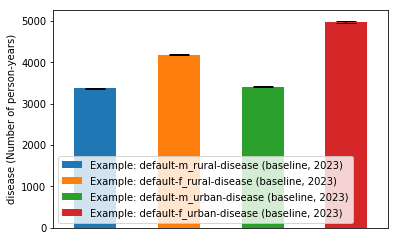

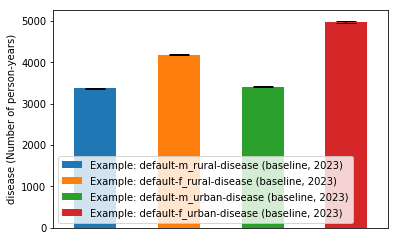

In [29]:
ensemble = at.Ensemble(name='Example',mapping_function=yld,baseline_results=baseline)
ensemble.update(sampled_res)
ensemble.plot_bars()

You can also use the `Ensemble.summary_statistics()` method to get a dataframe with summary statistics

In [33]:
ensemble.summary_statistics()

value
year result  output  pop     quantity             
NaN  default disease m_rural baseline  3366.597242
                             mean      3366.264405
                             median    3365.781120
                             max       3388.294149
                             min       3350.695377
                             Q1        3360.910464
                             Q3        3370.856405
                     f_rural baseline  4183.427099
                             mean      4182.657254
                             median    4181.683954
                             max       4228.526693
                             min       4137.189261
                             Q1        4173.486701
                             Q3        4194.277905
                     m_urban baseline  3402.221836
                             mean      3402.923093
                             median    3403.548971
                             max       3426.905727
                             min       3375.829211
                             Q1        3397.341206
                             Q3        3410.817999
                     f_urban baseline  4979.440732
                             mean      4979.459428
                             median    4977.297327
                             max       5029.834012
                             min       4917.939315
                             Q1        4964.578868
                             Q3        4994.872549

### Comparing sampled results

Moving up in complexity, a common analysis task is comparing results across scenarios. At the beginning, we instantiated two sets of instructions - one with default spending, and one with doubled spending. We will now produce samples from both of these instructions. There are two ways to approach this problem

- Storing the results in separate Ensembles
- Putting multiple results into a single Ensemble

To perform the analysis most validly, it is important to run the budget scenario in each of the instructions for the same parset and progset samples. That is, to generate a single result, it is necessary to first sample, and then use the same samples for all instructions. Written out explicitly, this would be

In [40]:
np.random.seed(3)
sampled_parset = parset.sample()
sampled_progset = high_uncertainty_progset.sample()
baseline = P.run_sim(sampled_parset,sampled_progset,default_budget,result_name='Baseline')
doubled = P.run_sim(sampled_parset,sampled_progset,doubled_budget,result_name='Doubled budget')

Elapsed time for running "default": 0.0280s
Elapsed time for running "default": 0.0290s


Comparing results across budget scenarios is extremely common, so Atomica has built-in functionality to facilitate this. You can pass multiple instructions and result names to `Project.run_sampled_sims()` to generate results as shown above  

In [43]:
sampled_res = P.run_sampled_sims(parset,high_uncertainty_progset,progset_instructions=[default_budget,doubled_budget],result_names=['Baseline','Doubled budget'])
print(sampled_res)

[[<atomica.results.Result at 0x15d14ad9cf8>
Methods:
  budget()            export_raw()        link_names()        
  charac_names()      get_alloc()         par_names()         
  comp_names()        get_coverage()      plot()              
  copy()              get_variable()      
    created: datetime.datetime(2019, 1, 29, 14, 29, 47, 201287)
      model: <atomica.model.Model object at 0x0000015D14AD74A8>
   modified: datetime.datetime(2019, 1, 29, 14, 29, 47, 201287)
       name: Baseline
parset_name: default
  pop_names: ['m_rural', 'f_rural', 'm_urban', 'f_urban']
        uid: UUID('ada240d1-2489-4a47-bb97-780b6143b172')
, <atomica.results.Result at 0x15d14b06828>
Methods:
  budget()            export_raw()        link_names()        
  charac_names()      get_alloc()         par_names()         
  comp_names()        get_coverage()      plot()              
  copy()              get_variable()      
    created: datetime.datetime(2019, 1, 29, 14, 29, 47, 228277)
      model: <a

The output is now a list of lists, where the inner list contains a set of results that has been generated with different instructions but the same sampled inputs. This is the input that would go to an `Ensemble` mapping function, to produce a `PlotData` instance that mixes results. Now, we can generate a plot comparing YLD in each population

In [44]:
sampled_res = P.run_sampled_sims(parset,high_uncertainty_progset,progset_instructions=[default_budget,doubled_budget],n_samples=100,result_names=['Baseline','Doubled budget'])

100%|████████████████████████████████████████| 100/100 [00:07<00:00, 13.52it/s]


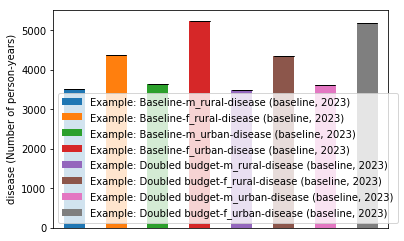

In [55]:
ensemble = at.Ensemble(name='Example',mapping_function=yld)
ensemble.update(sampled_res)
ensemble.plot_bars();

To aid comparison, it may be clearer to plot individual populations at a time. For example:

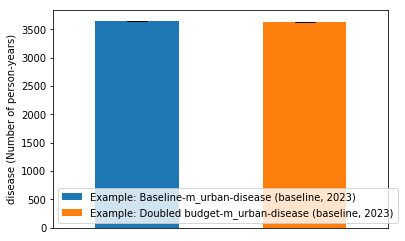

In [58]:
ensemble.plot_bars(pops='m_urban');

In this case, there isn't much difference because as shown in the time series, most of the variability is encountered in the initial simulation years. We can see this if we plot a quantity with more variability - for example, the number of undiagnosed people in the first simulation year

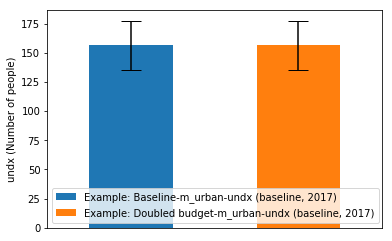

In [66]:
undx = lambda x: at.PlotData(x,outputs='undx',pops='m_urban')
ensemble = at.Ensemble(name='Example',mapping_function=undx)
ensemble.update(sampled_res)
ensemble.plot_bars(years=2017);

## Memory-limited environments
